### Build Our Model

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset = pd.read_csv('archive/english.csv')
directory = "archive"

imageDatas = []
files = dataset["image"]
label = dataset["label"]
dimention = "100x100"
npzFileName = "Uncompressed_" + dimention + ".npz"

# Load  compressed image matrix data
data = np.load(npzFileName)
ImageData_compressed = data['imageDatas_np']
print("=======done load======")

print(ImageData_compressed.shape)

=======done load======
(3410, 100, 100, 1)


## Data Preprocessing
### 1) center the char

In [5]:
def centerChar(Img):
    dimension = len(Img)
    location = locatChar(Img)
    
    resultImg = []
    for i in range(dimension):
        row = []
        for j in range(dimension):
            row += [[np.float32(1.0)]]
            
        resultImg += [row]
    
    offset_row = int((dimension-(location[1] + 1 -location[0]))/2)    
    offset_col = int((dimension-(location[3] + 1 -location[2]))/2)
    
    for i in range(0, location[1] + 1 - location[0]):
        for j in range(0, location[3] + 1 - location[2]):
            resultImg[i + offset_row][j + offset_col][0] = Img[i + location[0]][j + location[2]][0]
    
    
    resultImg = np.array(resultImg)
    return resultImg
    
def locatChar(Img):
    dimension = len(Img)
    top = dimension
    bottom = 0
    left = dimension
    right = 0
    
    for i in range(dimension):
        for j in range(dimension):
            if Img[i][j][0] < 0.2:
                if top > i:
                    top = i
                if bottom < i:
                    bottom = i
                if left > j:
                    left = j
                if right < j:
                    right = j
    return [top, bottom, left, right]

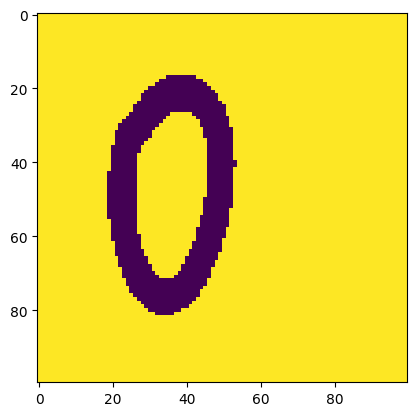

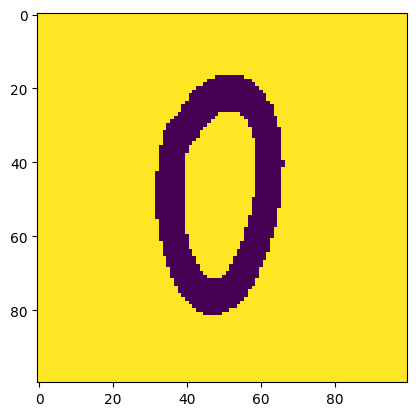

In [6]:
result = centerChar(ImageData_compressed[0])
plt.imshow(ImageData_compressed[0])
plt.show()
plt.imshow(result)
plt.show()

portion = (ImageData_compressed[0])[17:82, 19:54]
# plt.imshow(portion)
# plt.show()

In [7]:
# center all the data

ImageData_centered = []
count = 0
print("=====start processing=====")
for img in ImageData_compressed:
    img_c = centerChar(img)
    ImageData_centered += [img_c]
    
    count += 1
    if (count % 500 == 0):
        print("processed: ", count, " imgs" )

print("=====finish processing=====")

ImageData_centered = np.array(ImageData_centered)
print(ImageData_centered.shape)

=====start processing=====
processed:  500  imgs
processed:  1000  imgs
processed:  1500  imgs
processed:  2000  imgs
processed:  2500  imgs
processed:  3000  imgs
=====finish processing=====
(3410, 100, 100, 1)


In [5]:
import numpy
dimention = "100x100"
npzFileName = "Centered_" + dimention + ".npz"

# Save compressed data to NPZ file
# numpy.savez(npzFileName, ImageData_centered=ImageData_centered)
# print("=======done saving======")

In [7]:
import numpy
import pandas as pd
import numpy as np

dataset = pd.read_csv('archive/english.csv')
directory = "archive"

imageDatas = []
files = dataset["image"]
label = dataset["label"]
dimention = "100x100"
npzFileName = "Centered_" + dimention + ".npz"

# Load  compressed image matrix data
data = numpy.load(npzFileName)
ImageData_centered = data['ImageData_centered']
print("=======done loading=======")

print(ImageData_centered.shape)

=======done loading=======
(3410, 100, 100, 1)


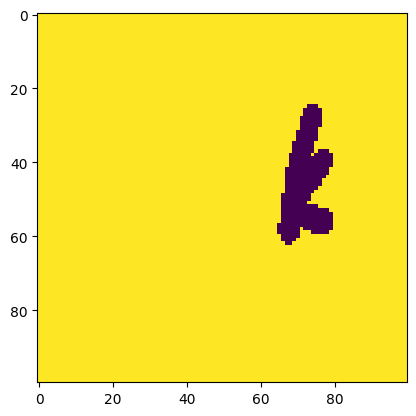

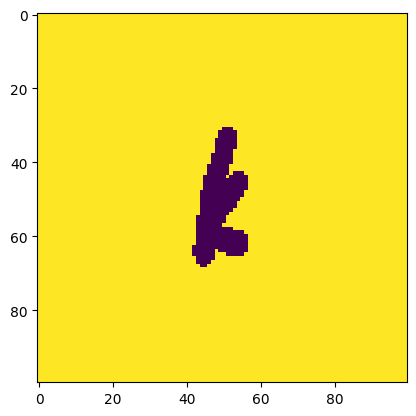

In [8]:
plt.imshow(ImageData_compressed[2578])
plt.show()
plt.imshow(ImageData_centered[2578])
plt.show()

In [9]:
def getIndex(letter):
    index = ord(letter)-48
    if (index > 10):
        index -= 7
    if (index > 35):
        index -= 6
    return index

In [10]:
import random

data_nparr = ImageData_centered
label_nparr = np.array(label)

test_index = []
# Randomly select 6 items from each group of 55
selected_indices = []
print(label_nparr.shape)
for i in range(0, len(label_nparr), 55):
    charGroup = data_nparr[i:i+55]
    indices = random.sample(range(i, i+55), 10)
    test_index.extend(indices)

test_index_nparr = np.array(test_index)
print(test_index_nparr.shape)

train_data, test_data, train_label, test_label = [], [], [], []
for i in range(len(label_nparr)):
    if i in test_index:
        test_data += [data_nparr[i]]
        test_label += [getIndex(label_nparr[i])]
    else:
        train_data += [data_nparr[i]]
        train_label += [getIndex(label_nparr[i])]

train_data = np.array(train_data)
test_data = np.array(test_data)
train_label = np.array(train_label)
test_label = np.array(test_label)

train_label_onehot = pd.get_dummies(train_label) # one-hot enc
test_label_onehot = pd.get_dummies(test_label) # one-hot enc

print(train_data.shape)

(3410,)
(620,)
(2790, 100, 100, 1)


In [94]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image

def apply_rotation_augmentation(images):
    # Convert the images to TensorFlow tensors
    images_tensor = tf.convert_to_tensor(images)

    # Reshape the images tensor to (some_amount, height, width, channels)
    images_tensor = tf.reshape(images_tensor, [len(images), 100, 100, 1])

    # Generate random rotation angles between -5 and 5 degrees for each image
    rotation_angles = tf.random.uniform(shape=[len(images)], minval=-10, maxval=10)

    # Apply rotation augmentation and resize to each image
    rotated_images = []
    for i in range(len(images)):
        img = tf.keras.preprocessing.image.array_to_img(images_tensor[i])
        img = img.rotate(rotation_angles[i])
        img = img.resize((116, 116), resample=Image.NEAREST)
        img = img.crop((8, 8, 108, 108)) 
        rotated_img = tf.keras.preprocessing.image.img_to_array(img)
        rotated_images.append(rotated_img)
    
    rotated_images = tf.convert_to_tensor(rotated_images)

    return rotated_images

In [95]:
train_data_augmented = train_data
print("=============Start Augmentation=============")
for i in range(5):
    train_data_augmented = np.concatenate((train_data_augmented, apply_rotation_augmentation(train_data[i * 500:(i + 1) * 500])), axis=0)
    print("processed ", (i + 1) * 500, " Img")
    
train_data_augmented = np.concatenate((train_data_augmented, apply_rotation_augmentation(train_data[2500:2790])), axis=0)
print("=============Finish Augmentation=============")
print(train_data_augmented.shape)

=============Start Augmentation=============
processed  500  Img
processed  1000  Img
processed  1500  Img
processed  2000  Img
processed  2500  Img
=============Finish Augmentation=============
(5580, 100, 100, 1)


In [96]:
train_label_augmented = np.concatenate((train_label, train_label), axis=0)
train_label_augmented_onehot = pd.get_dummies(train_label_augmented)
print(train_label.shape)
print(train_label_augmented_onehot.shape)

(2790,)
(5580, 62)


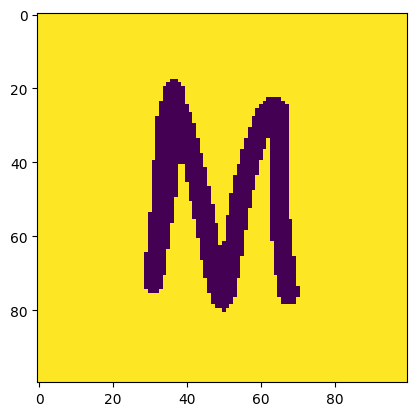

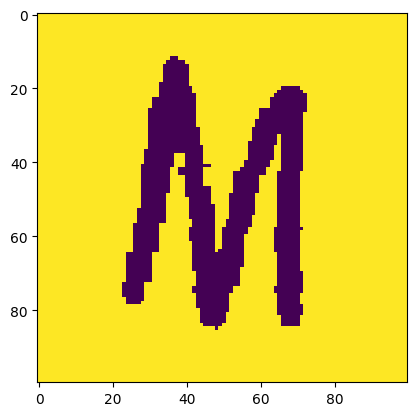

In [97]:
index_check = 1000;
plt.imshow(train_data_augmented[index_check])
plt.show()
plt.imshow(train_data_augmented[index_check + 2790])
plt.show()

# Grid Search

In [127]:
def create_model(kernel_size1 = 3, kernel_size2 = 3, regulazation_p = 0.01, dense_node = 128, drop_out_rate = 0.1):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (kernel_size1, kernel_size1), activation='relu', input_shape=data_nparr[0].shape, kernel_regularizer=regularizers.l2(regulazation_p)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (kernel_size2, kernel_size2), activation='relu', kernel_regularizer=regularizers.l2(regulazation_p)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(regulazation_p)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(dense_node, activation='relu', kernel_regularizer=regularizers.l2(regulazation_p)))
    model.add(layers.Dropout(drop_out_rate))
    model.add(layers.Dense(62, activation='softmax'))
    
    return model

print("====function made=====")

====function made=====


In [213]:
# Print the best parameters and accuracy for 64 dense node
print("Best Parameters: ", best_params)
print("Best Accuracy: ", best_accuracy)

Best Parameters:  {'dense_node': 64, 'drop_out_rate': 0.18, 'kernel_size1': 3, 'kernel_size2': 3, 'regulazation_p': 0.01}
Best Accuracy:  0.8080645203590393


In [217]:
# Print the best parameters and accuracy for 64, 128, 256 dense node
print("Best Parameters: ", best_params)
print("Best Accuracy: ", best_accuracy)

Best Parameters:  {'dense_node': 256, 'drop_out_rate': 0.18, 'kernel_size1': 3, 'kernel_size2': 3, 'regulazation_p': 0.012}
Best Accuracy:  0.7983871102333069


In [211]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

# Define the hyperparameters and their values to search over
param_grid = {
    'kernel_size1': [3, 5],
    'kernel_size2': [3, 5],
    'regulazation_p': [0.01, 0.008, 0.012],
    'dense_node': [64],  # [, 128, 256], dense_node search in seperate block
    'drop_out_rate': [0.1, 0.18, 0.25],
}


print("==========started grid search============")
# Perform grid search
best_accuracy = 0
best_params = None
best_augmented = False

for params in ParameterGrid(param_grid):
    print("\n\n",params , "  Augmented")
    # use non-augmented data
    model = create_model(**params)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    history = model.fit(train_data_augmented, train_label_augmented_onehot, epochs=20, 
                        validation_data=(test_data, test_label_onehot))
    
    # Evaluate model on validation data
    accuracy_index = numpy.argmax(history.history['val_accuracy'])
    accuracy = history.history['val_accuracy'][accuracy_index]
    print("current best accuracy", accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_augmented = False
        print("updated best")
        
    
    print("\n\n", params , "  Not-Augmented")
    # use Augmented data
    model = create_model(**params)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    history = model.fit(train_data, train_label_onehot, epochs=20, 
                        validation_data=(test_data, test_label_onehot))
    
    accuracy_index = numpy.argmax(history.history['val_accuracy'])
    accuracy = history.history['val_accuracy'][accuracy_index]
    print("current best accuracy", accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_augmented = True
        print("updated best")

print("==========finished grid search============\n\n")
# Print the best parameters and accuracy
print("Best Parameters: ", best_params)
print("Best Accuracy: ", best_accuracy)
print("Best Augmented: ", best_augmented)

==========started grid search============


 {'dense_node': 64, 'drop_out_rate': 0.1, 'kernel_size1': 3, 'kernel_size2': 3, 'regulazation_p': 0.01}   Augmented
Epoch 1/20
175/175 [==============================] - 21s 118ms/step - loss: 6.8732 - accuracy: 0.0199 - val_loss: 5.4096 - val_accuracy: 0.0516
Epoch 2/20
175/175 [==============================] - 20s 115ms/step - loss: 4.8074 - accuracy: 0.1287 - val_loss: 4.6530 - val_accuracy: 0.1339
Epoch 3/20
175/175 [==============================] - 20s 116ms/step - loss: 3.2241 - accuracy: 0.3849 - val_loss: 2.7777 - val_accuracy: 0.4952
Epoch 4/20
175/175 [==============================] - 20s 117ms/step - loss: 2.3601 - accuracy: 0.5686 - val_loss: 2.3139 - val_accuracy: 0.5774
Epoch 5/20
175/175 [==============================] - 21s 118ms/step - loss: 1.9764 - accuracy: 0.6333 - val_loss: 1.9800 - val_accuracy: 0.6403
Epoch 6/20
175/175 [==============================] - 21s 118ms/step - loss: 1.6959 - accuracy: 0.6835 - val_loss: 

KeyboardInterrupt: 

In [212]:

# Print the best parameters and accuracy
print("Best Parameters: ", best_params)
print("Best Accuracy: ", best_accuracy)

Best Parameters:  {'dense_node': 64, 'drop_out_rate': 0.18, 'kernel_size1': 3, 'kernel_size2': 3, 'regulazation_p': 0.01}
Best Accuracy:  0.8080645203590393


In [216]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

# Define the hyperparameters and their values to search over
param_grid = {
    'kernel_size1': [3],
    'kernel_size2': [3],
    'regulazation_p': [0.01, 0.012],
    'dense_node': [128, 256], # dense_node search on 128, 256 on strinked scope
    'drop_out_rate': [0.18],
}


print("==========started grid search============")
# Perform grid search
best_accuracy = 0
best_params = None
best_augmented = False

for params in ParameterGrid(param_grid):
    print("\n\n",params , "  Augmented")
    # use non-augmented data
    model = create_model(**params)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    history = model.fit(train_data_augmented, train_label_augmented_onehot, epochs=20, 
                        validation_data=(test_data, test_label_onehot))
    
    # Evaluate model on validation data
    accuracy_index = numpy.argmax(history.history['val_accuracy'])
    accuracy = history.history['val_accuracy'][accuracy_index]
    print("current best accuracy", accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_augmented = False
        print("updated best")
        
    
    print("\n\n", params , "  Not-Augmented")
    # use Augmented data
    model = create_model(**params)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    history = model.fit(train_data, train_label_onehot, epochs=20, 
                        validation_data=(test_data, test_label_onehot))
    
    accuracy_index = numpy.argmax(history.history['val_accuracy'])
    accuracy = history.history['val_accuracy'][accuracy_index]
    print("current best accuracy", accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_augmented = True
        print("updated best")

print("==========finished grid search============\n\n")
# Print the best parameters and accuracy
print("Best Parameters: ", best_params)
print("Best Accuracy: ", best_accuracy)
print("Best Augmented: ", best_augmented)

==========started grid search============


 {'dense_node': 128, 'drop_out_rate': 0.18, 'kernel_size1': 3, 'kernel_size2': 3, 'regulazation_p': 0.01}   Augmented
Epoch 1/20
175/175 [==============================] - 22s 120ms/step - loss: 6.7835 - accuracy: 0.1613 - val_loss: 5.6219 - val_accuracy: 0.2113
Epoch 2/20
175/175 [==============================] - 21s 122ms/step - loss: 3.6987 - accuracy: 0.4466 - val_loss: 3.2205 - val_accuracy: 0.5306
Epoch 3/20
175/175 [==============================] - 21s 122ms/step - loss: 2.6389 - accuracy: 0.6194 - val_loss: 2.6036 - val_accuracy: 0.6161
Epoch 4/20
175/175 [==============================] - 21s 122ms/step - loss: 2.1449 - accuracy: 0.6903 - val_loss: 2.2101 - val_accuracy: 0.6581
Epoch 5/20
175/175 [==============================] - 22s 123ms/step - loss: 1.8228 - accuracy: 0.7376 - val_loss: 1.9822 - val_accuracy: 0.7145
Epoch 6/20
175/175 [==============================] - 21s 122ms/step - loss: 1.6207 - accuracy: 0.7638 - val_loss